In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

# Add the path to the custom library
custom_library_path = os.path.abspath('util/processing/')
sys.path.append(custom_library_path)

import extraction_squares, pre_processing_data

'''if operating_system == 'curnagl':
    name_of_variable= pd.read_csv('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS/variable_list_80_mean.csv')
    path_data = '/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS'
else:'''
name_of_variable= pd.read_csv('data/variable_list_levels.csv')
path_data = 'data'

storm_dates = pd.read_csv('pre_processing/tracks/storm_dates.csv')
path_tracks_1h = 'pre_processing/tracks/ALL_TRACKS/tracks_1h'
#path_tracks_1h_non_EU = 'pre_processing/tracks/ALL_TRACKS/tracks_1h_non_EU'
#dataset = 'datasets_1h'
#dataset_non_EU = 'datasets_1h_non_EU'
levels = pd.read_csv('data/levels.csv')

In [ ]:
test = pd.read_csv('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/time_series_1h_non_EU/2m_dewpoint_temperature/2m_dewpoint_temperature_max.csv')
test_2 = pd.read_csv('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/time_series_1h_non_EU/2m_dewpoint_temperature/2m_dewpoint_temperature_mean.csv')
# drop Unnamed: 0
test = test.drop(columns=['Unnamed: 0'])
test_2 = test_2.drop(columns=['Unnamed: 0'])
# add them in a 3D array
test = test.to_numpy()
test_2 = test_2.to_numpy()
# add a column with the name of variable written as many times as the number of rows
name = '2m_dewpoint_temperature_max'
name = np.repeat(name, test.shape[0])
name = name[:, np.newaxis]
test = np.concatenate((name, test), axis=1)
test = np.expand_dims(test, axis=0)
'''name = '2m_dewpoint_temperature_mean'
name = np.repeat(name, test_2.shape[0])
name = name[:, np.newaxis]
test_2 = np.concatenate((name, test_2), axis=1)

test = np.stack((test, test_2), axis=2)

test_3 = pd.read_csv('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/time_series_1h_non_EU/2m_temperature/2m_temperature_min.csv')
test_3 = test_3.drop(columns=['Unnamed: 0'])
test_3 = test_3.to_numpy()
name = '2m_temperature_min'
name = np.repeat(name, test_3.shape[0])
name = name[:, np.newaxis]
test_3 = np.concatenate((name, test_3), axis=1)

#test = np.stack((test, test_3), axis=2)'''

"name = '2m_dewpoint_temperature_mean'\nname = np.repeat(name, test_2.shape[0])\nname = name[:, np.newaxis]\ntest_2 = np.concatenate((name, test_2), axis=1)\n\ntest = np.stack((test, test_2), axis=2)\n\ntest_3 = pd.read_csv('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/time_series_1h_non_EU/2m_temperature/2m_temperature_min.csv')\ntest_3 = test_3.drop(columns=['Unnamed: 0'])\ntest_3 = test_3.to_numpy()\nname = '2m_temperature_min'\nname = np.repeat(name, test_3.shape[0])\nname = name[:, np.newaxis]\ntest_3 = np.concatenate((name, test_3), axis=1)\n\n#test = np.stack((test, test_3), axis=2)"

In [ ]:
# open time series data

stats = ['max', 'min', 'mean', 'std']
name_of_variable_levels = pd.read_csv('data/variable_list_levels.csv')

# shape all_data as the timeseries data
data_list = []
data_list_y = []
y_var_name = []
x_var_name = []

for var in name_of_variable_levels['variables']:
    for stat in stats:
        var_stat = f'{var}_{stat}'
        if var_stat == f'instantaneous_10m_wind_gust_{stat}':
            storm_data = []
            var_temp = pd.read_csv(f'data/time_series_1h_non_EU/{var}/{var}_{stat}.csv')
            var_temp = var_temp.drop(columns=['Unnamed: 0'])
            '''var_temp = var_temp.to_numpy()
            name = np.repeat(var_stat, var_temp.shape[0])
            name = name[:, np.newaxis]
            var_temp = np.concatenate((name, var_temp), axis=1)'''
            storm_data.append(var_temp)
            y_var_name.append(var_stat)

            data_list_y.append(storm_data)
        else :
            storm_data = []
            var_temp = pd.read_csv(f'data/time_series_1h_non_EU/{var}/{var}_{stat}.csv')
            var_temp = var_temp.drop(columns=['Unnamed: 0'])
            '''var_temp = var_temp.to_numpy()
            name = np.repeat(var_stat, var_temp.shape[0])
            name = name[:, np.newaxis]
            var_temp = np.concatenate((name, var_temp), axis=1)'''
            storm_data.append(var_temp)
            x_var_name.append(var_stat)

            data_list.append(storm_data)

# order of the data: storm, step, variable_stat
all_data = np.stack(data_list, axis=3)
all_data = np.concatenate(all_data, axis=0)

all_data_y = np.stack(data_list_y, axis=3)
all_data_y = np.concatenate(all_data_y, axis=0)
'''# keep only the max of the instantaneous wind gust
all_data_y = all_data_y[:, 0, :]
y_var_name = y_var_name[0]
'''
# get the storm indices
storm_indices = all_data[:,0, 0]
# Convert to float first, then to int
storm_indices = storm_indices.astype(float).astype(int)
# separate the data in training and testing
storm_index_training, storm_index_test, storm_index_validation = extraction_squares.split_storm_numbers(storm_indices)

# order the index of the storms

storm_index_training.sort()
storm_index_test.sort()
storm_index_validation.sort()

print("Storm Training:", storm_index_training)
print("Storm Test:", storm_index_test)
print("Storm Valid:", storm_index_validation) 

Storm Training: [ 2  3  5  7  8 13 16 19 27 31 32 33 34 39 43 46 47 49 50 53 54 56 58 62
 64 68 69 71 72 76 77 78 80 81 82 83 85 89 90 95]
Storm Test: [29 38 45 48 66 86 87 93]
Storm Valid: [ 6 21 44 60 61 63 65 73 79]


In [3]:
X_train = []
y_train = []
for i in range(storm_index_training.astype(int).shape[0]): 
    temp = all_data[all_data[:,0,0] == storm_index_training[i], :, :]
    temp_y = all_data_y[all_data_y[:,0,0] == storm_index_training[i], :,:]
    X_train.append(temp)
    y_train.append(temp_y)

X_train = np.concatenate(X_train, axis=0)
X_train = X_train[:, 1:, :]
y_train = np.concatenate(y_train, axis=0)
y_train = y_train[:, 1:,:]

X_test = []
y_test = []
for i in range(storm_index_test.astype(int).shape[0]): 
    temp = all_data[all_data[:,0,0] == storm_index_test[i], :, :]
    temp_y = all_data_y[all_data_y[:,0,0] == storm_index_test[i], :,:]
    X_test.append(temp)
    y_test.append(temp_y)

X_test = np.concatenate(X_test, axis=0)
X_test = X_test[:, 1:, :]
y_test = np.concatenate(y_test, axis=0)
y_test = y_test[:, 1:,:]

X_validation = []
y_validation = []

for i in range(storm_index_validation.astype(int).shape[0]):
    temp = all_data[all_data[:,0,0] == storm_index_validation[i], :, :]
    temp_y = all_data_y[all_data_y[:,0,0] == storm_index_validation[i], :,:]
    X_validation.append(temp)
    y_validation.append(temp_y)

X_validation = np.concatenate(X_validation, axis=0)
X_validation = X_validation[:, 1:, :]
y_validation = np.concatenate(y_validation, axis=0)
y_validation = y_validation[:, 1:,:]

# add one dimension for each y

'''y_train = np.expand_dims(y_train, axis=2)
y_test = np.expand_dims(y_test, axis=2)
y_validation = np.expand_dims(y_validation, axis=2)'''


'y_train = np.expand_dims(y_train, axis=2)\ny_test = np.expand_dims(y_test, axis=2)\ny_validation = np.expand_dims(y_validation, axis=2)'

In [4]:
# X_train
X_train_standardized, y_train_standardized_max, y_train_standardized_mean, var_stat_all_x = pre_processing_data.data_preparation_ML(X_train, y_train, name_of_variable, levels)
# X_test 
X_test_standardized, y_test_standardized_max, y_test_standardized_mean, var_stat_all_x = pre_processing_data.data_preparation_ML(X_test, y_test, name_of_variable, levels)
# X_validation
X_validation_standardized, y_validation_standardized_max, y_validation_standardized_mean, var_stat_all_x = pre_processing_data.data_preparation_ML(X_validation, y_validation, name_of_variable, levels)

In [5]:
# check if there are nan values
print(np.isnan(X_train_standardized).any())

# remove colmuns with nan values
X_train_standardized = X_train_standardized.dropna(axis=1)
X_test_standardized = X_test_standardized.dropna(axis=1)
X_validation_standardized = X_validation_standardized.dropna(axis=1)

2m_dewpoint_temperature_max     False
2m_dewpoint_temperature_min     False
2m_dewpoint_temperature_mean    False
2m_dewpoint_temperature_std     False
2m_temperature_max              False
                                ...  
vertical_velocity_975_std       False
vertical_velocity_1000_max      False
vertical_velocity_1000_min      False
vertical_velocity_1000_mean     False
vertical_velocity_1000_std      False
Length: 316, dtype: bool


In [6]:
# Create a random forest Regressor
rf_max = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)
rf_mean = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)

# Create a xgb Regressor
xgb_max = xgb.XGBRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)
xgb_mean = xgb.XGBRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)

# Create a GradientBoosting Regressor
gb_max = GradientBoostingRegressor(n_estimators = 100, random_state = 42)
gb_mean = GradientBoostingRegressor(n_estimators = 100, random_state = 42)

# Create a DecisionTree Regressor
dt_max = DecisionTreeRegressor(random_state = 42)
dt_mean = DecisionTreeRegressor(random_state = 42)

# Create a Logistic Regression
log_reg_max = LogisticRegression(random_state = 42)
log_reg_mean = LogisticRegression(random_state = 42)

# Train the model on training data
#rf_max.fit(X_all_2d_non_na, y_max)
#rf_mean.fit(X_all_2d_non_na, y_mean)
rf_max.fit(X_train_standardized, y_train_standardized_max)
rf_mean.fit(X_train_standardized, y_train_standardized_mean)

xgb_max.fit(X_train_standardized, y_train_standardized_max)
xgb_mean.fit(X_train_standardized, y_train_standardized_mean)

gb_max.fit(X_train_standardized, y_train_standardized_max)
gb_mean.fit(X_train_standardized, y_train_standardized_mean)

dt_max.fit(X_train_standardized, y_train_standardized_max)
dt_mean.fit(X_train_standardized, y_train_standardized_mean)

#log_reg_max.fit(X_train_standardized, y_train_standardized_max)
#log_reg_mean.fit(X_train_standardized, y_train_standardized_mean)

/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages

DecisionTreeRegressor(random_state=42)

In [7]:
# See the prediction of the model on the test data
#predictions_max = rf_max.predict(X_all_2d_non_na)
#predictions_mean = rf_mean.predict(X_all_2d_non_na)
rf_predictions_max = rf_max.predict(X_test_standardized)

#xgb_predictions_max = xgb_max.predict(X_all_2d_non_na)
#xgb_predictions_mean = xgb_mean.predict(X_all_2d_non_na)
xgb_predictions_max = xgb_max.predict(X_test_standardized)

#gb_predictions_max = gb_max.predict(X_all_2d_non_na)
#gb_predictions_mean = gb_mean.predict(X_all_2d_non_na)
gb_predictions_max = gb_max.predict(X_test_standardized)

#dt_predictions_max = dt_max.predict(X_all_2d_non_na)
#dt_predictions_mean = dt_mean.predict(X_all_2d_non_na)
dt_predictions_max = dt_max.predict(X_test_standardized)

#log_reg_predictions_max = log_reg_max.predict(X_all_2d_non_na)
#log_reg_predictions_mean = log_reg_mean.predict(X_all_2d_non_na)
#log_reg_predictions_max = log_reg_max.predict(X_test_standardized)

# Calculate mean squared error

mse_rf_max = mean_squared_error(y_test_standardized_max, rf_predictions_max)
mse_xgb_max = mean_squared_error(y_test_standardized_max, xgb_predictions_max)
mse_gb_max = mean_squared_error(y_test_standardized_max, gb_predictions_max)
mse_dt_max = mean_squared_error(y_test_standardized_max, dt_predictions_max)

In [8]:
# Get the feature importance
importances_rf_max = rf_max.feature_importances_
importances_xgb_max = xgb_max.feature_importances_
importances_gb_max = gb_max.feature_importances_
importances_dt_max = dt_max.feature_importances_

# Sort the feature importance in descending order
indices_rf_max = np.argsort(importances_rf_max)[::-1]
indices_xgb_max = np.argsort(importances_xgb_max)[::-1]
indices_gb_max = np.argsort(importances_gb_max)[::-1]
indices_dt_max = np.argsort(importances_dt_max)[::-1]

# Sort the name of the variables
var_stat_all_rf_sorted_max = [X_test_standardized.columns[i] for i in indices_rf_max]
var_stat_all_xgb_sorted_max = [X_test_standardized.columns[i] for i in indices_xgb_max]
var_stat_all_gb_sorted_max = [X_test_standardized.columns[i] for i in indices_gb_max]
var_stat_all_dt_sorted_max = [X_test_standardized.columns[i] for i in indices_dt_max]


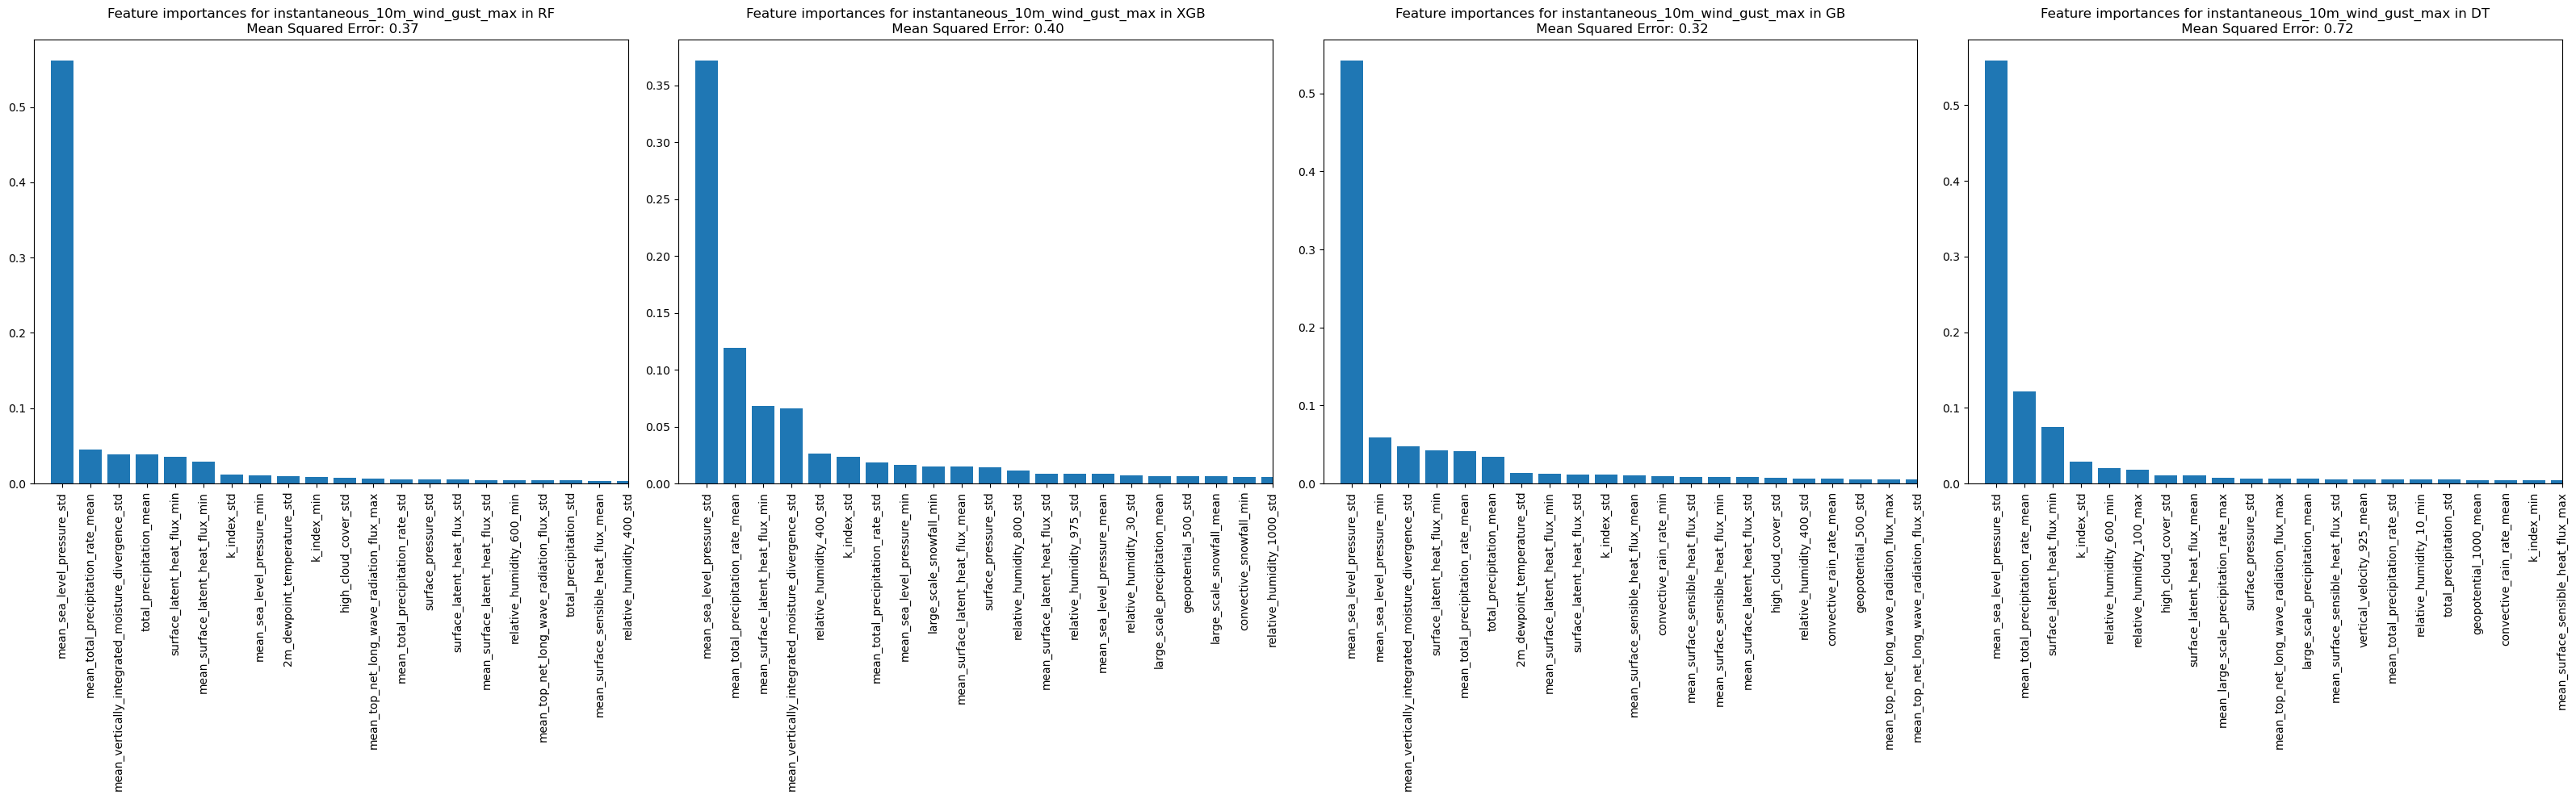

In [13]:
# Plot the feature importances of the forest
subset = 20

'''# plot only the feature importance with wind gust max and set the variables on the y axis for xgb
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_title("Feature importances for instantaneous_10m_wind_gust_max")
ax.barh(range(subset), importances_max_xgb[indices_max][:subset], align="center")
ax.set_yticks(range(subset))
ax.set_yticklabels(var_stat_all_sorted_max[:subset])
# Reverse the y-axis
ax.invert_yaxis()'''

# with 2 plots, 1 for the max and 1 for the mean

fig, axes = plt.subplots(1, 4, figsize=(32, 10))  # 4 rows, 1 column

axes[0].set_title("Feature importances for instantaneous_10m_wind_gust_max in RF\n Mean Squared Error: %.2f" % mse_rf_max)
axes[0].bar(range(X_test_standardized.shape[1]), importances_rf_max[indices_rf_max], align="center")
axes[0].set_xticks(range(X_test_standardized.shape[1]), var_stat_all_rf_sorted_max, rotation=90)
axes[0].set_xlim([-1, subset])

axes[1].set_title("Feature importances for instantaneous_10m_wind_gust_max in XGB\n Mean Squared Error: %.2f" % mse_xgb_max)
axes[1].bar(range(X_test_standardized.shape[1]), importances_xgb_max[indices_xgb_max], align="center")
axes[1].set_xticks(range(X_test_standardized.shape[1]), var_stat_all_xgb_sorted_max, rotation=90)
axes[1].set_xlim([-1, subset])

axes[2].set_title("Feature importances for instantaneous_10m_wind_gust_max in GB\n Mean Squared Error: %.2f" % mse_gb_max)
axes[2].bar(range(X_test_standardized.shape[1]), importances_gb_max[indices_gb_max], align="center")
axes[2].set_xticks(range(X_test_standardized.shape[1]), var_stat_all_gb_sorted_max, rotation=90)
axes[2].set_xlim([-1, subset])

axes[3].set_title("Feature importances for instantaneous_10m_wind_gust_max in DT\n Mean Squared Error: %.2f" % mse_dt_max)
axes[3].bar(range(X_test_standardized.shape[1]), importances_dt_max[indices_dt_max], align="center")
axes[3].set_xticks(range(X_test_standardized.shape[1]), var_stat_all_dt_sorted_max, rotation=90)
axes[3].set_xlim([-1, subset])

plt.tight_layout()
plt.show()